In [ ]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

# Manifold Statistics - Examples on $\mathbb{S}^2$

In [1]:
from src.manifolds.S2 import *
M = S2(use_spherical_coords=True,chart_center='x')
print(M)

from src.plotting import *

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


2d sphere (ellipsoid parameters [1. 1. 1.], spherical_coords: True)


In [2]:
# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

# geodesics
from src.Riemannian import geodesic
geodesic.initialize(M)

# Logarithm map
from src.Riemannian import Log
Log.initialize(M)

using M.Exp for Logarithm


## Sample Data

In [ ]:
# coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

N_samples = 256
x = np.array([np.pi/2,np.pi/2])

samples = np.zeros((N_samples,M.dim.eval()))
for i in range(N_samples):
    (ts,xs) = M.Brownian_coordsf(x,dWsf(M.dim.eval()))
    samples[i] = xs[-1]

# plot
newfig()
M.plot()
for i in range(N_samples):
    M.plotx(samples[i])
plt.show()

## Frechet mean

In [ ]:
from src.statistics.Frechet_mean import *

res = Frechet_mean(M,lambda *args: M.Logf(*args), samples)
Fm = res[0]
print("loss = ", res[1])
print("mean = ", Fm)
iterations = res[2]

newfig()
M.plot(rotate = np.array([50,-45]))
M.plotx(Fm)
M.plotx(iterations)
plt.show()

## Tangent PCA

In [ ]:
from src.statistics.tangent_PCA import *

from src.utils import *
from sklearn.decomposition import PCA

pca = tangent_PCA(M,lambda *args: M.Logf(*args),x,samples)
print(pca.get_covariance())

plt.scatter(pca.transformed_Logs[:, 0], pca.transformed_Logs[:, 1])
plt.axis('equal')
plt.show()

# ML mean estimation

In [ ]:
options = {}
options['samples_per_obs'] = 1
options['epochs'] = 50
options['learning_rate'] = .5e0
options['varphi_update_rate'] = 1.
options['initial'] = [np.array([0.,x[1]/8])]#[x+.5*np.random.randn(M.dim.eval())]
options['verbose'] = True

In [ ]:
# Delyon/Hu guided process
from src.stochastics.guided_process import *

# guide function
Cholesky = T.slinalg.Cholesky()
# phi = lambda q,v: T.tensordot(T.nlinalg.MatrixInverse()(Cholesky(M.gsharp(q))),-(q-v).flatten(),(1,0))
phi = lambda q,v: T.tensordot(Cholesky(M.g(q)).T,-(q-v).flatten(),(1,0))
x0 = M.element()
(Brownian_coords_guided,Brownian_coords_guidedf) = get_guided_likelihood(M,M.sde_Brownian_coords,phi,lambda x: Cholesky(M.gsharp(x)),x0)

In [ ]:
# Transition density
# transition density etc.
q0 = M.element()
v = M.element()
thetas = (q0,)
log_p_Tf = theano.function([q0,v],log_p_T(q0,v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords))
dlog_p_Tf = theano.function([q0,v],dlog_p_T(thetas,q0,v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords))
p_Tf = theano.function([q0,v],T.exp(log_p_T(q0,v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords)))

v = x
%time print(log_p_Tf(x,v))
%time print(p_Tf(x,v))
%time print(dlog_p_Tf(x,v))

In [ ]:
from src.statistics.mle import *

def llog_p_T(thetas,pars):
    (v,seed) = pars
    if seed:
        srng.seed(seed)
    q = thetas[0]
    return dlog_p_Tf(q,v)

def update_thetas(thetas, dthetas):
    q = thetas[0]
    
    q += options['learning_rate']*np.dot(M.gsharpf(q),dthetas[0]) # use Riemannian g-gradient
    
    return (q,)

In [ ]:
# run MLE
(thetas, log_likelihood, log_likelihoods, thetass) = iterative_mle(samples,llog_p_T,update_thetas,options)

# plot
plt.plot(range(options['epochs']),log_likelihoods)
# plt.savefig('ML_likelihoods.pdf')
plt.show()
plt.plot(range(options['epochs']),thetass[0].reshape((thetass[0].shape[0],-1)))
# plt.savefig('ML_thetas.pdf')
plt.show()

M.newfig()
M.plot()
M.plotx(thetas[0],s=150)
M.plotx(np.vstack((options['initial'][0],thetass[0])),color='blue',linewidth=2.5)
M.plotx(Fm,s=150,color='red')
M.plotx(np.vstack((np.zeros((1,2)),iterations)),color='red',linewidth=2.5)
plt.savefig('MLmean_iterations.pdf')
plt.show()

# Two-sample test (Huilling Le)

In [3]:
# Stochastic development
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

from src.framebundle import FM
FM.initialize(M)
from src.stochastics import stochastic_development
stochastic_development.initialize(M)
from src.stochastics import Brownian_development
Brownian_development.initialize(M)

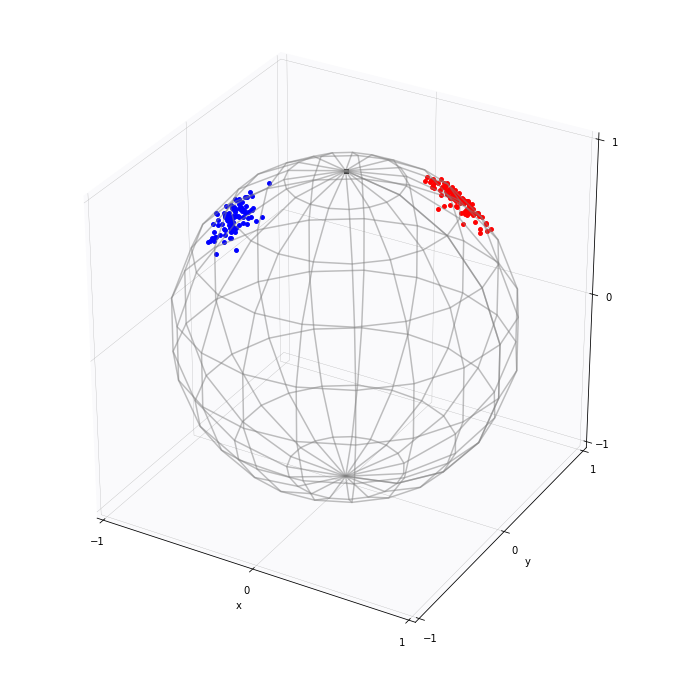

In [4]:
N_samples = 100

# Mean of sample distributions
x = np.array([np.pi/2+0.5,np.pi/2+0.5])
y = np.array([np.pi/2-0.5,np.pi/2-0.5])

# chart point:
p = np.array([np.pi/2,np.pi/2])

x_sample = np.zeros((N_samples,M.dim.eval()))
y_sample = np.zeros((N_samples,M.dim.eval()))
for i in range(N_samples):
    (tsx,xs) = M.Brownian_developmentf(x,0.1*dWsf(M.dim.eval()))
    x_sample[i] = xs[-1]
    (tsy,ys) = M.Brownian_developmentf(y,0.1*dWsf(M.dim.eval()))
    y_sample[i] = ys[-1]

# plot
%matplotlib inline
newfig()
M.plot()
for i in range(N_samples):
    M.plotx(x_sample[i], color = 'b')
    M.plotx(y_sample[i], color = 'r')
    M.plotx(p, color = 'k')
plt.show()

In [18]:
# Two sample test:
def h(x,y,p_chart):
    # x, y tangent vectors
    qx = M.Expf(p_chart,x)
    qy = M.Expf(p_chart,y)
    
    return np.linalg.norm(M.Logf(qx,qy)[0])**2

def hessh(x,y,p_chart):
    # x,y tangent vectors
    return T.hessian(M.Exp(p_chart,y)[0],y)
x = T.vector()
y = T.vector()
p1 = T.vector()
hesshf = theano.function([x,y,p1], hessh(x,y,p1), on_unused_input='ignore')

ERROR (theano.gof.opt): SeqOptimizer apply <theano.gof.opt.EquilibriumOptimizer object at 0x7f70d8089e10>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 235, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 87, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 2497, in apply
    sub_prof = gopt.apply(fgraph)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 2071, in apply
    q = deque(graph.io_toposort(fgraph.inputs, start_from))
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/graph.py", line 1031, in io_toposort
    deps_cache=deps_cache, clients=clients)
  File "/home/li

ERROR (theano.gof.opt): SeqOptimizer apply <theano.compile.mode.AddDestroyHandler object at 0x7f713b8b26a0>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 235, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 83, in optimize
    self.add_requirements(fgraph)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/compile/mode.py", line 116, in add_requirements
    fgraph.attach_feature(gof.DestroyHandler())
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/fg.py", line 541, in attach_feature
    attach(self)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/destroyhandler.py", line 744, in on_attach
    toolbox.Bookkeeper.on_attach(self, fgraph)
  File "/home/line/Dropb

ERROR (theano.gof.opt): SeqOptimizer apply <TopoOptimizer instance>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 235, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 87, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 2071, in apply
    q = deque(graph.io_toposort(fgraph.inputs, start_from))
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/graph.py", line 1031, in io_toposort
    deps_cache=deps_cache, clients=clients)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/graph.py", line 961, in general_toposort
    raise ValueError('graph contains cycles')
ValueError: graph contains cyc


ERROR (theano.gof.opt): SeqOptimizer apply make_ger_destructive
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 235, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 87, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/opt.py", line 2071, in apply
    q = deque(graph.io_toposort(fgraph.inputs, start_from))
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/graph.py", line 1031, in io_toposort
    deps_cache=deps_cache, clients=clients)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/theano/gof/graph.py", line 961, in general_toposort
    raise ValueError('graph contains cycles')
ValueError: graph contains cycles

ValueError: graph contains cycles

In [ ]:
p0 = np.array([np.pi/2,np.pi/2])
x0 = np.array([1.,1.])
y0 = np.array([0.5,0.5])
print(hesshf(x0,y0,p0))

In [47]:
from src.statistics.Frechet_mean import *

# Frechet mean of X
resx = Frechet_mean(M,lambda *args: M.Logf(*args), x_sample)
Fmx = resx[0]
print("loss = ", resx[1])
print("mean = ", Fmx)
iterationsx = resx[2]

# Frechet mean of Y
resy = Frechet_mean(M,lambda *args: M.Logf(*args), y_sample)
Fmy = resy[0]
print("loss = ", resy[1])
print("mean = ", Fmy)
iterationsy = resy[2]

newfig()
M.plot()#rotate = np.array([50,-45]))
M.plotx(Fmx)
M.plotx(iterationsx)
M.plotx(Fmy)
M.plotx(iterationsy)
plt.show()

Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/multiprocess/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/line/Dropbox/theanogeometry/lib/python3.5/site-packages/multiprocess/pool.py", line 119, in worker
    result = (True, func(

KeyboardInterrupt: 

In [ ]:
Logx = np.zeros((N_samples,M.dim.eval()))
Logy = np.zeros((N_samples,M.dim.eval()))
for i in range(N_samples):
    Logx = M.Logf(p,x_sample[i])[0]
    Logy = M.Logf(p,y_sample[i])[0]